In [2]:
!pip install timm

In [3]:
# Reference: https://pytorch.org/hub/intelisl_midas_v2/

In [4]:
import cv2
import torch

In [5]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /pt/torch/hub/intel-isl_MiDaS_master
/opt/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
    

In [7]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /pt/torch/hub/intel-isl_MiDaS_master


In [8]:
import os.path
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")

if os.path.isfile(filename):
    print("Image file exists")
else:
    import urllib.request
    urllib.request.urlretrieve(url, filename)
    print("Image file downloaded")

Image file exists


In [9]:
imgname = filename
img = cv2.imread(imgname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [10]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

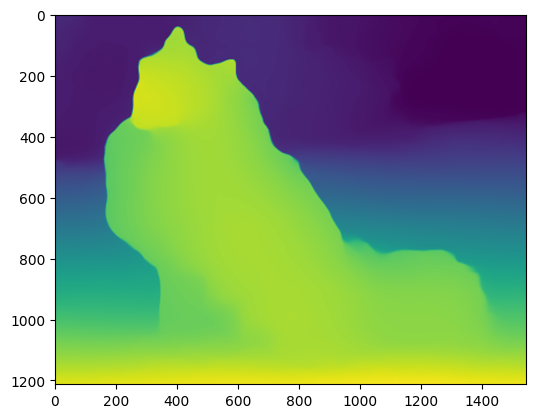

In [11]:
import matplotlib.pyplot as plt
plt.imshow(output, cmap='viridis')

In [12]:
output.shape

(1213, 1546)

In [13]:
output

array([[ 4.144983  ,  4.1465044 ,  4.1483016 , ...,  0.39974496,
         0.41411912,  0.41889995],
       [ 4.147438  ,  4.148834  ,  4.1503563 , ...,  0.39397642,
         0.4072693 ,  0.41170728],
       [ 4.1550713 ,  4.1560607 ,  4.1566706 , ...,  0.377632  ,
         0.38753426,  0.3908982 ],
       ...,
       [34.09196   , 34.094204  , 34.101574  , ..., 34.858154  ,
        34.851208  , 34.849415  ],
       [34.08498   , 34.08911   , 34.10303   , ..., 34.892303  ,
        34.873676  , 34.86853   ],
       [34.0856    , 34.09022   , 34.10579   , ..., 34.904503  ,
        34.88227   , 34.876087  ]], shape=(1213, 1546), dtype=float32)